# TrpCage: mindist and rmsdCA model

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma
import mdtraj as md
from glob import glob

## Define auxiliary functions

Here, we define a set of functions which will make plotting easier.

In [2]:
def plot_its(lags, model, bayesian_model, ax, ylabel, dt=2.0E-4, confidence_interval=0.98):
    cout = 50 * (1.0 - confidence_interval)
    ax.fill_between(
        lags * dt,
        0.0,
        lags * dt,
        alpha=0.5, facecolor='grey')
    ax.plot(lags * dt, lags * dt, linewidth=2, color='black')
    for i in range(model.shape[1]):
        ax.fill_between(
            lags * dt,
            np.percentile(bayesian_model[:, :, i], cout, axis=1),
            np.percentile(bayesian_model[:, :, i], 100 - cout, axis=1),
            alpha=0.3, facecolor='C%d' % i)
        ax.plot(lags * dt, model[:, i], color='C%d' % i)
        ax.plot(lags * dt, np.median(bayesian_model[:, :, i], axis=1), ':o', color='C%d' % i)
    ax.set_xlabel(r'lagtime / $\mu$s')
    ax.set_ylabel(ylabel)
    
def get_lagtime_from_array(lags, lagtime, dt=2.0E-4):
    idx = np.argmin(np.abs(lags * dt - lagtime))
    return idx, lags[idx]

def get_free_energy(tics, bins=100, use=[0, 1]):
    z, xedge, yedge = np.histogram2d(*tics[:, use].T, bins=bins)
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])
    z = np.maximum(z, np.min(z[z > 0]))
    f = -np.log(z)
    f -= np.min(f)
    xx, yy = np.meshgrid(x, y)
    xy = np.array([xx.reshape(-1,), yy.reshape(-1,)]).T
    return dict(x=x, y=y, xx=xx, yy=yy, xy=xy, f=f.T, use=use)

def draw_free_energy(fe, ax, bw=False):
    if bw:
        cmap = mpl.cm.bone
        alpha=0.2
    else:
        cmap = mpl.cm.jet
        alpha=None
    levels = np.linspace(fe['f'].min(), fe['f'].max(), 100, endpoint=False)
    return ax.contourf(fe['x'], fe['y'], fe['f'], levels, cmap=cmap, alpha=alpha, vmin=0.0, vmax=np.max(fe['f']))

def get_metastable_distribution(model, state):
    pi = model.stationary_distribution.copy()
    for i, s in enumerate(model.metastable_sets):
        if i == state:
            continue
        pi[s] = 0.0
    pi /= pi.sum()
    return pi

## Data source

In [ ]:
path = '/home/esuarez/Documents/DESHAWTRAJS/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/'
trajs = '2JOF-0-protein-*.dcd'

traj_files = [f for f in sorted(glob(path + trajs))]
pdb_file = path + 'protein.pdb'

## Create a feature reader


In [3]:
features = pyemma.coordinates.featurizer(pdb_file)
features.add_residue_mindist()
features.add_minrmsd_to_ref(path + '2JOF-0-protein-000.dcd', ref_frame=4250)
source = pyemma.coordinates.source([traj_files], features=features, chunk_size=10000)

19-07-17 12:45:01 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs


## RMSD

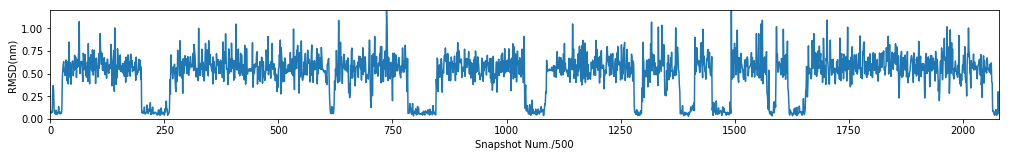

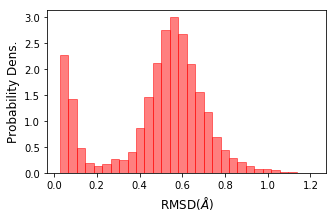

In [4]:
reference = md.load_dcd(path + '2JOF-0-protein-000.dcd', top=pdb_file)

CA_atoms = reference.topology.select('name CA and resid 1 to 18')

rmsd = []

for traj_name in traj_files:
    traj = md.load_dcd(traj_name, top=pdb_file)
    for element in md.rmsd(traj, reference, 4250, atom_indices=CA_atoms):
        rmsd.append(element)

fig = plt.figure(figsize=(17, 2))
plt.plot(rmsd[::500])
plt.axis([0, 2080, 0.0, 1.2])
plt.ylabel('RMSD(nm)')
plt.xlabel('Snapshot Num./500')
plt.show()


#histogram
fig = plt.figure(figsize=(5, 3))

ax1 = fig.add_subplot(111)
ax1.hist(rmsd[::100], normed=True, bins=30, color='r', alpha=0.5, edgecolor='r')
ax1.set_xlabel('RMSD$(\AA)$', fontsize=12)
ax1.set_ylabel('Probability Dens.', fontsize=12)

# to Angstrom
rmsd = np.array(rmsd) * 10.0

## Discretization

19-07-17 13:40:51 pyemma.coordinates.clustering.kmeans.KmeansClustering[6] INFO     Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


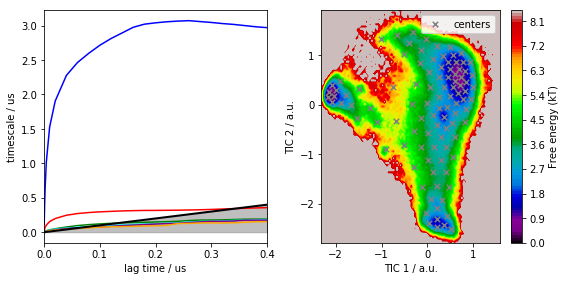

In [6]:
tica = pyemma.coordinates.tica(data=source, lag=5, dim=2).get_output()[0]
cluster = pyemma.coordinates.cluster_kmeans(tica, k=100, max_iter=50)

lags = np.asarray([1, 5, 10, 20, 50] + [i * 100 for i in range(1, 21)])
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(cluster.dtrajs, lags=lags, errors=None, nits=6),
    ylog=False, ax=axes[0], units='us', dt=2.0E-4)
pyemma.plots.plot_free_energy(*tica.T, ax=axes[1])
axes[1].scatter(*cluster.clustercenters.T, marker='x', c='grey', s=30, label='centers')
axes[1].legend()
axes[1].set_xlabel('TIC 1 / a.u.')
axes[1].set_ylabel('TIC 2 / a.u.')
fig.tight_layout()

## MSM estimation and analysis

The ITS convergence suggests to use a lagtime of $\tau\approx0.2\mu s$ and two or maybe even three metastable states. Let's do a quick analysis whether we can actually build a reasonable MSM for the given discretization. We start with the suggested lagtime and do CK tests for the suspected amouts of metastable states.

Estimated at lagtime 1000 steps


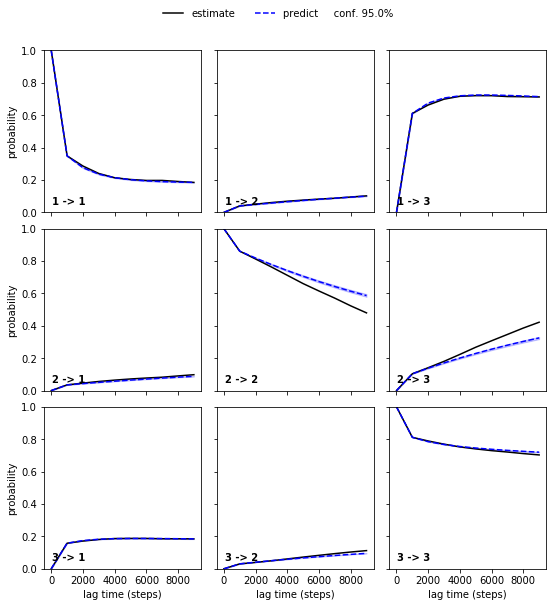

In [10]:
lag = get_lagtime_from_array(lags, 0.2, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(3))
print('Estimated at lagtime %d steps' % lag)

Estimated at lagtime 1000 steps


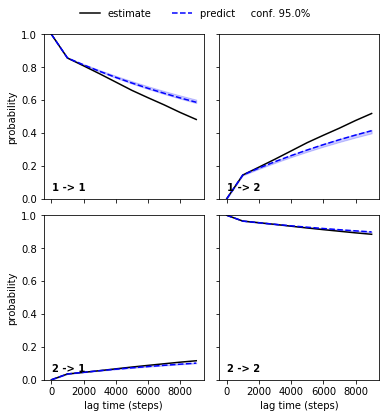

In [11]:
lag = get_lagtime_from_array(lags, 0.2, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(2))
print('Estimated at lagtime %d steps' % lag)

That does not look good! Even though the implied timescales look converged, I would not plce much trust in this.

Let's check for higher lagtimes!

Estimated at lagtime 1200 steps


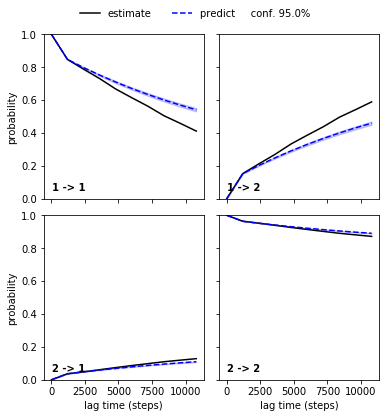

In [14]:
lag = get_lagtime_from_array(lags, 0.25, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(2))
print('Estimated at lagtime %d steps' % lag)

Estimated at lagtime 1500 steps


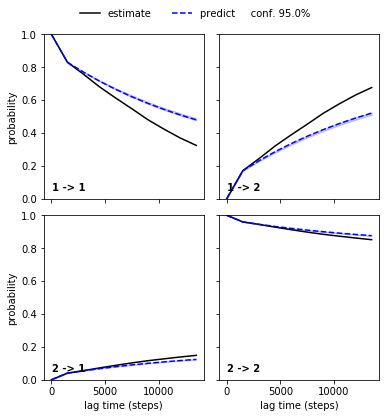

In [17]:
lag = get_lagtime_from_array(lags, 0.3, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(2))
print('Estimated at lagtime %d steps' % lag)

Looks like it gets even worse. How about smaller lagtimes?

Estimated at lagtime 700 steps


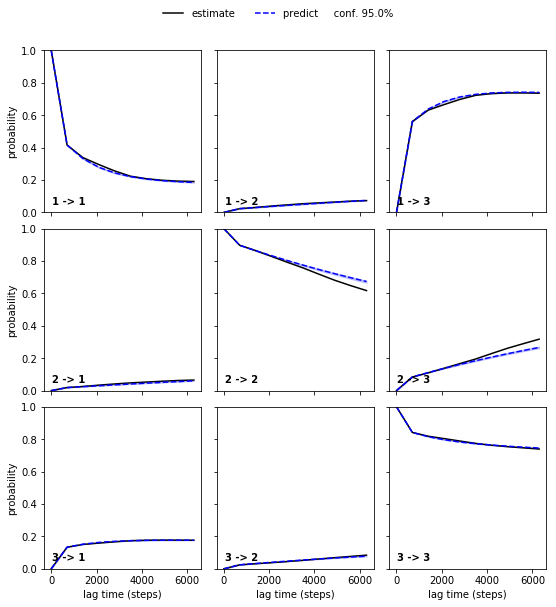

In [18]:
lag = get_lagtime_from_array(lags, 0.15, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(3))
print('Estimated at lagtime %d steps' % lag)

Estimated at lagtime 700 steps


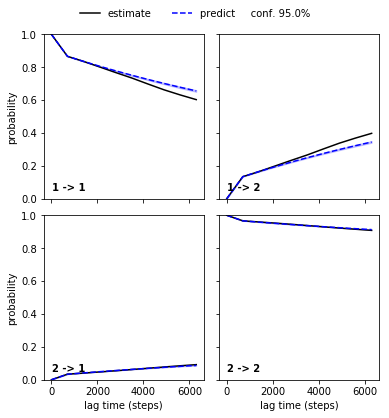

In [19]:
lag = get_lagtime_from_array(lags, 0.15, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(2))
print('Estimated at lagtime %d steps' % lag)

Estimated at lagtime 500 steps


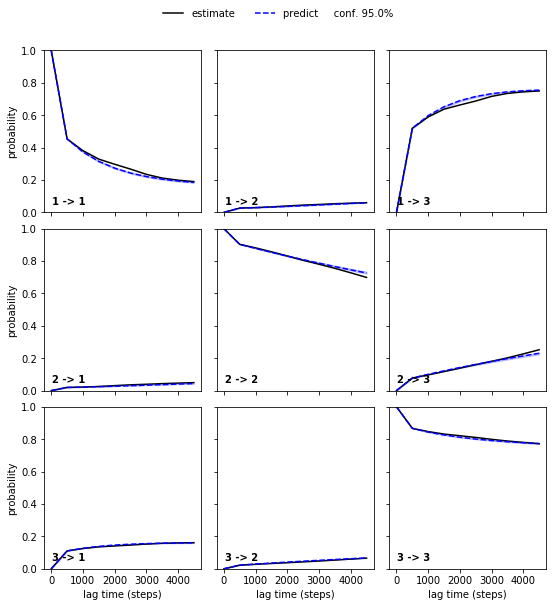

In [20]:
lag = get_lagtime_from_array(lags, 0.1, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(3))
print('Estimated at lagtime %d steps' % lag)

Estimated at lagtime 500 steps


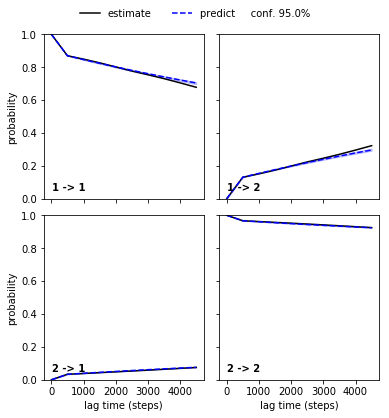

In [21]:
lag = get_lagtime_from_array(lags, 0.1, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(2))
print('Estimated at lagtime %d steps' % lag)

We have either Markovian data or converged implied timescales, but not both. Conclusion: we need a better data set to work on!

## Discretization - RMSD only

The RMSD data for itself already looks kindof metastable. Let's build an MSM on top of that.

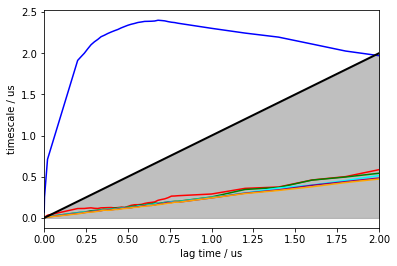

In [26]:
features = pyemma.coordinates.featurizer(pdb_file)
features.add_minrmsd_to_ref(path + '2JOF-0-protein-000.dcd', ref_frame=4250)
rmsd = pyemma.coordinates.load([traj_files], features=features, chunk_size=10000)
centers = np.linspace(rmsd.min(), rmsd.max(), 101)
centers = 0.5 * (centers[1:] + centers[:-1]).reshape(-1, 1)
dtraj = pyemma.coordinates.assign_to_centers(rmsd, centers=centers)

lags = np.asarray([1, 10, 100] + [1000 + i * 100 for i in range(30)] + [1000 * i for i in range(4, 11)])
pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(dtraj, lags=lags, errors=None, nits=6),
    ylog=False, units='us', dt=2.0E-4)

This type of data yields a lower ITS maximum than the previous situation and requires a very high lagtime to achieve convergence. I do not expect a good MSM for this situation, either, but let's do a CK test for the converged plateau anyway...

Estimated at lagtime 2700 steps


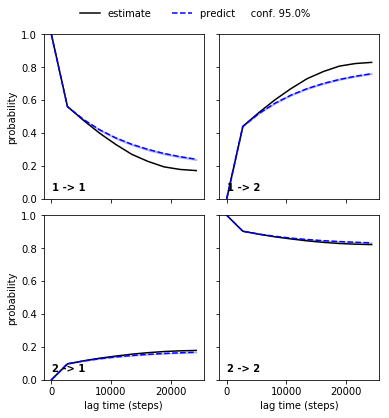

In [27]:
lag = get_lagtime_from_array(lags, 0.55, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(dtraj, lag=lag, dt_traj='0.0002 us').cktest(2))
print('Estimated at lagtime %d steps' % lag)

The CK test fails and I recommend to discard this type of data as well.

## Discretization - how about heavy atom distances?

It is possible that residue minimum distances by themselfs are not sufficient, here. Let's try heavy atom distances and regspace clustering instead while keeping the TICA settings.

In [40]:
features = pyemma.coordinates.featurizer(pdb_file)
features.add_distances(features.select_Heavy())
source = pyemma.coordinates.source([traj_files], features=features, chunk_size=10000)

19-07-17 16:26:08 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[30] WARNING  The 1D arrays input for add_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features


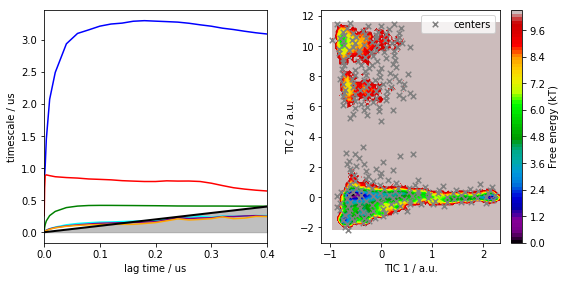

In [50]:
tica = pyemma.coordinates.tica(data=source, lag=5, dim=2).get_output()[0]
cluster = pyemma.coordinates.cluster_regspace(tica, max_centers=500, dmin=0.2)

lags = np.asarray([1, 5, 10, 20, 50] + [i * 100 for i in range(1, 21)])
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(cluster.dtrajs, lags=lags, errors=None, nits=6),
    ylog=False, ax=axes[0], units='us', dt=2.0E-4)
pyemma.plots.plot_free_energy(*tica.T, ax=axes[1])
axes[1].scatter(*cluster.clustercenters.T, marker='x', c='grey', s=30, label='centers')
axes[1].legend()
axes[1].set_xlabel('TIC 1 / a.u.')
axes[1].set_ylabel('TIC 2 / a.u.')
fig.tight_layout()

We do observe a slightly better ITS convergence and higher ITS maximum than in the first attempt. We also resolve two faster processes. The CK test, however, fails for most combinations of more than two metastable states and lagtimes above $\tau=0.1\mu s$. The best result is shown below:

Estimated at lagtime 500 steps


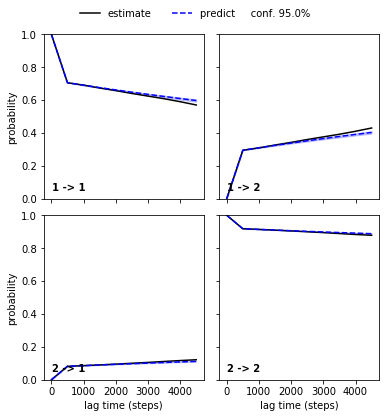

In [64]:
lag = get_lagtime_from_array(lags, 0.1, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(2))
print('Estimated at lagtime %d steps' % lag)

For this parameter choice, we build an MSM and
- find two metastable states via PCCA,
- show the free energy surface in TICA space with the metastable state partitioning, and
- compute mean first passage times (MFPTs) between the metastable states.

PI = [0.17553704636352854, 0.8244629536364716]
MFPT[0, 1] =  4 us
MFPT[1, 0] = 16 us


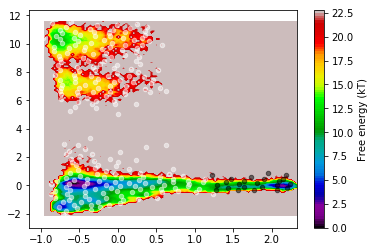

In [82]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us')
msm.pcca(2)
fig, ax = pyemma.plots.plot_free_energy(*tica.T, weights=msm.pi[cluster.dtrajs])
ax.scatter(*cluster.clustercenters[msm.metastable_sets[0], :].T, s=20, c='black', alpha=0.5)
ax.scatter(*cluster.clustercenters[msm.metastable_sets[1], :].T, s=20, c='white', alpha=0.5)
print('PI = ' + str([msm.pi[s].sum() for s in msm.metastable_sets]))
print('MFPT[0, 1] = %2.0f us' % msm.mfpt(msm.metastable_sets[0], msm.metastable_sets[1]))
print('MFPT[1, 0] = %2.0f us' % msm.mfpt(msm.metastable_sets[1], msm.metastable_sets[0]))

## ToDo
- [ ] Are ``dim=2`` and ``lag=2`` good settings for TICA in this case?
- [ ] Do we need the RMSD feature? Test: Check correlation of the RMSD feature with all TICs.
- [ ] Do we need heavy atom distances or do the residue mindistances suffice with better TICA settings?